# Intro
Welcome to the [VinBigData Chest X-ray Abnormalities Detection](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/data) compedition.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/24800/logos/header.png)

We consider 14 critical radiographic findings as listed below (click for further informations):

0 - [Aortic enlargement](https://en.wikipedia.org/wiki/Aortic_aneurysm) <br>
1 - [Atelectasis](https://en.wikipedia.org/wiki/Atelectasis) <br>
2 - [Calcification](https://en.wikipedia.org/wiki/Calcification) <br>
3 - [Cardiomegaly](https://en.wikipedia.org/wiki/Cardiomegaly) <br>
4 - [Consolidation](https://en.wikipedia.org/wiki/Pulmonary_consolidation) <br>
5 - [ILD](https://en.wikipedia.org/wiki/Interstitial_lung_disease) <br>
6 - [Infiltration](https://en.wikipedia.org/wiki/Infiltration_(medical)) <br>
7 - [Lung Opacity](https://en.wikipedia.org/wiki/Ground-glass_opacity) <br>
8 - [Nodule/Mass](https://en.wikipedia.org/wiki/Lung_nodule) <br>
9 - Other lesion <br>
10 - [Pleural effusion](https://en.wikipedia.org/wiki/Pleural_effusion) <br>
11 - [Pleural thickening](https://en.wikipedia.org/wiki/Pleural_thickening) <br>
12 - [Pneumothorax](https://en.wikipedia.org/wiki/Pneumothorax) <br>
13 - [Pulmonary fibrosis](https://en.wikipedia.org/wiki/Pulmonary_fibrosis#:~:text=Pulmonary%20fibrosis%20is%20a%20condition,%2C%20pneumothorax%2C%20and%20lung%20cancer.)

<span style="color: royalblue;">Please vote the notebook up if it helps you. Feel free to leave a comment above the notebook. Thank you. </span>

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.1'

# Libraries

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pydicom as dicom
import cv2

import warnings
warnings.filterwarnings("ignore")

# Path

In [4]:
path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/'
os.listdir(path)

['sample_submission.csv', 'train.csv', 'test', 'train']

# Load Data

In [5]:
train_data = pd.read_csv(path+'train.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')

# Overview

In [6]:
print('Number train samples:', len(train_data.index))
print('Number test samples:', len(samp_subm.index))

Number train samples: 67914
Number test samples: 3000


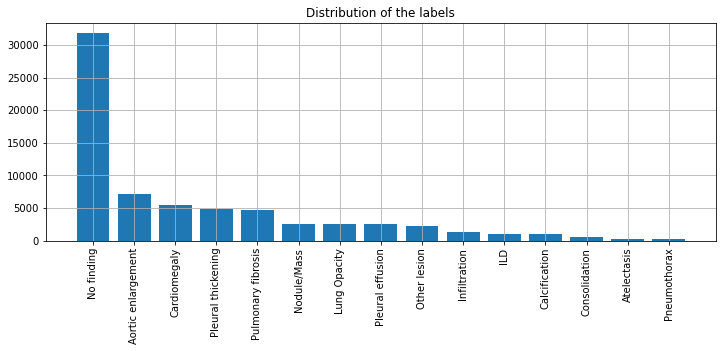

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
x = train_data['class_name'].value_counts().keys()
y = train_data['class_name'].value_counts().values
ax.bar(x, y)
ax.set_xticklabels(x, rotation=90)
ax.set_title('Distribution of the labels')
plt.grid()
plt.show()

As we can see the dataset is inbalanced.

# Read dicom Files

In [8]:
idnum = 2
image_id = train_data.loc[idnum, 'image_id']
data_file = dicom.dcmread(path+'train/'+image_id+'.dicom')
img = data_file.pixel_array

Print meta data of the image:

In [9]:
print(data_file)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 158
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9a5094b2563a1ef3ff50dc5c7ff71345
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's Age                       AS: '061Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 2336
(0028, 0011) Columns                             US: 2080
(0028, 0100) Bits Al

In [10]:
print('Image shape:', img.shape)

Image shape: (2336, 2080)


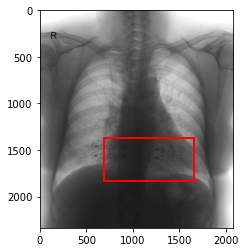

In [11]:
bbox = [train_data.loc[idnum, 'x_min'],
        train_data.loc[idnum, 'y_min'],
        train_data.loc[idnum, 'x_max'],
        train_data.loc[idnum, 'y_max']]
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.imshow(img, cmap='gray')
p = matplotlib.patches.Rectangle((bbox[0], bbox[1]),
                                 bbox[2]-bbox[0],
                                 bbox[3]-bbox[1],
                                 ec='r', fc='none', lw=2.)
ax.add_patch(p)
plt.show()

# Show Examples
Plot 3 images of every class with the bounding boxes:

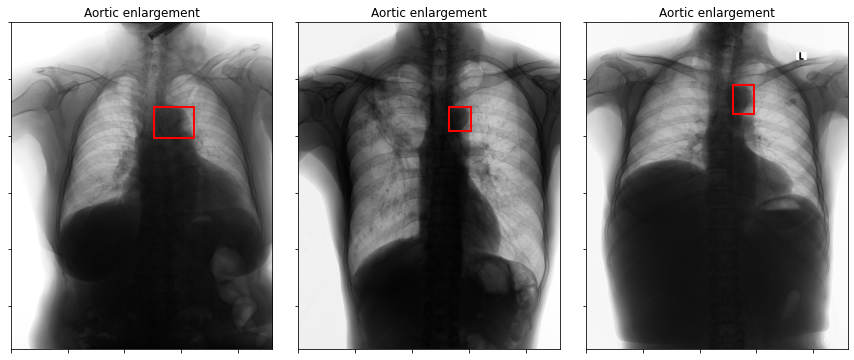

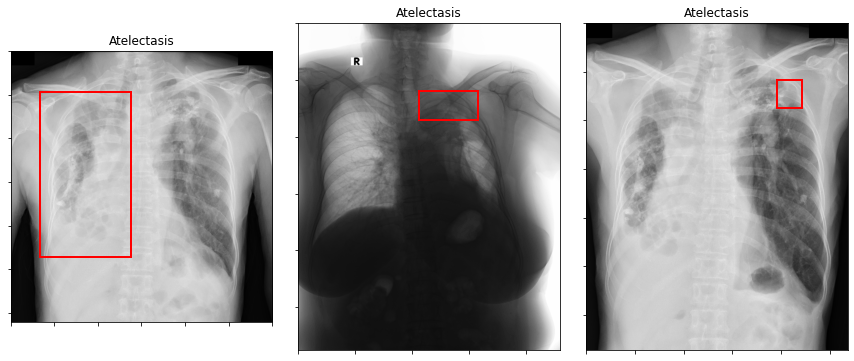

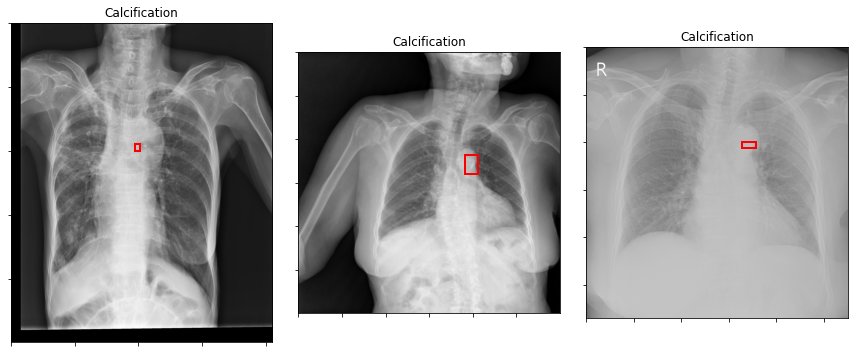

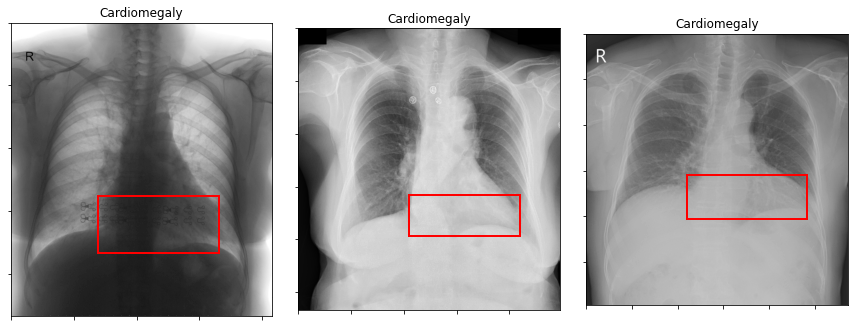

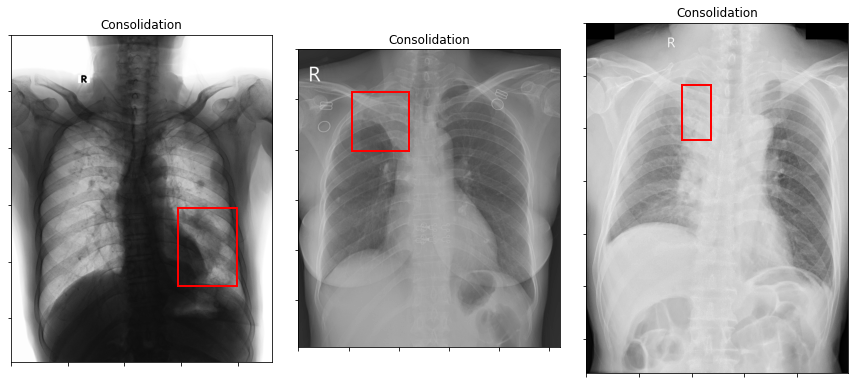

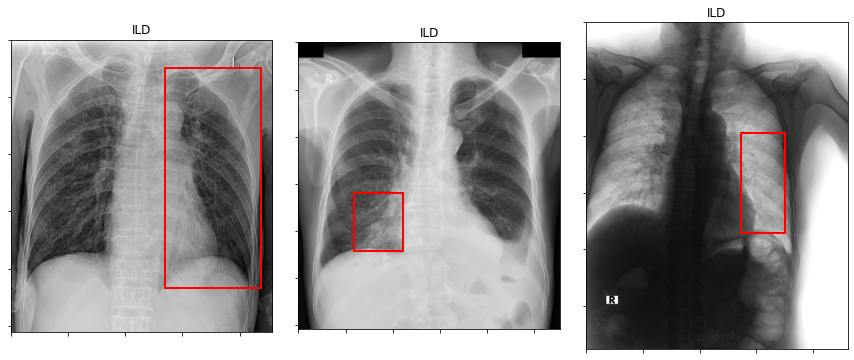

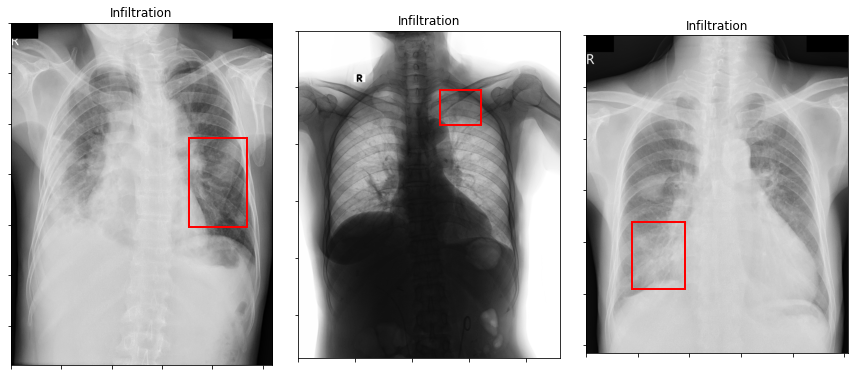

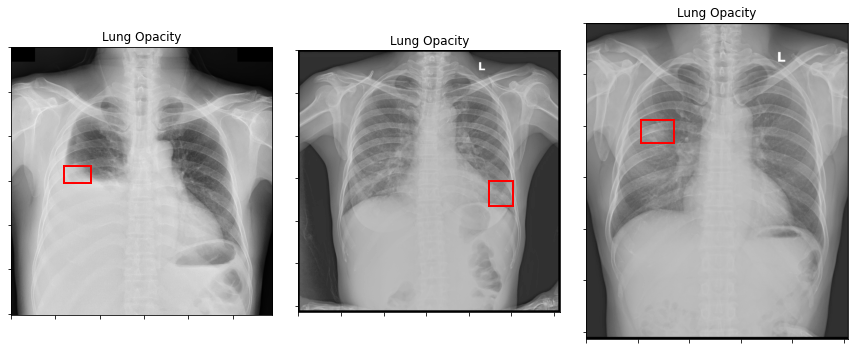

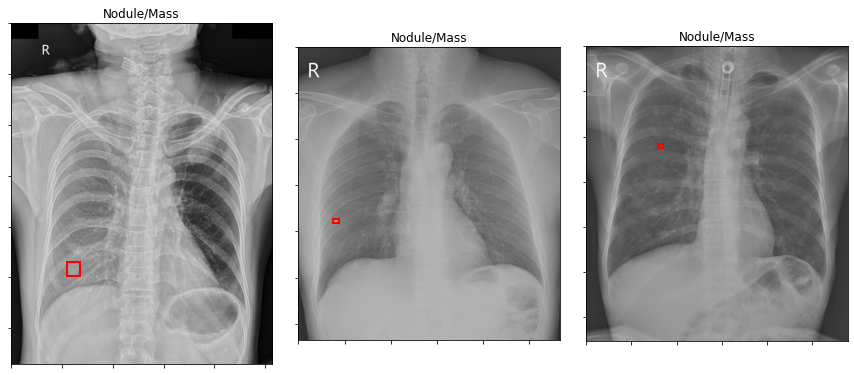

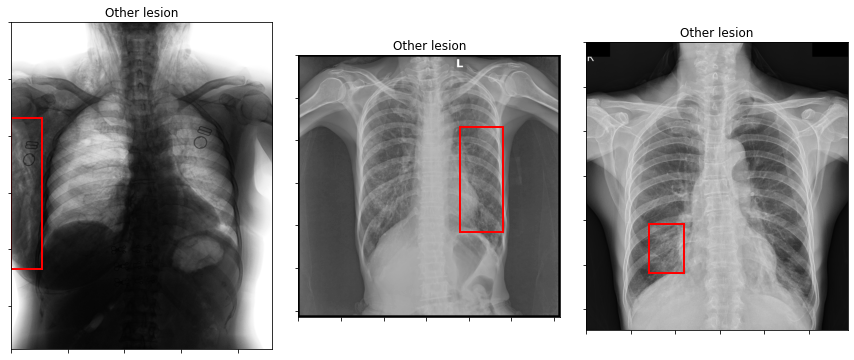

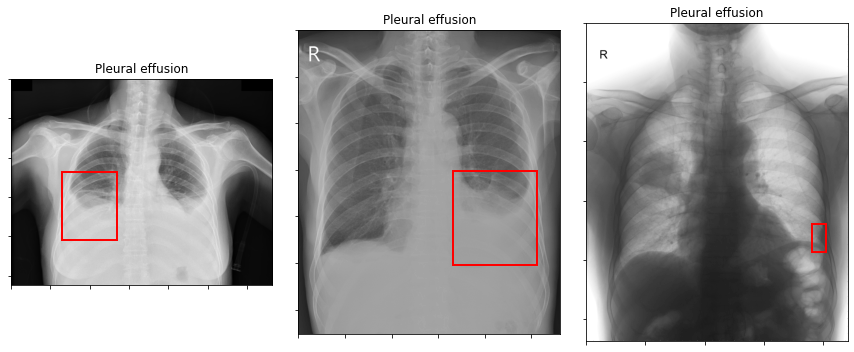

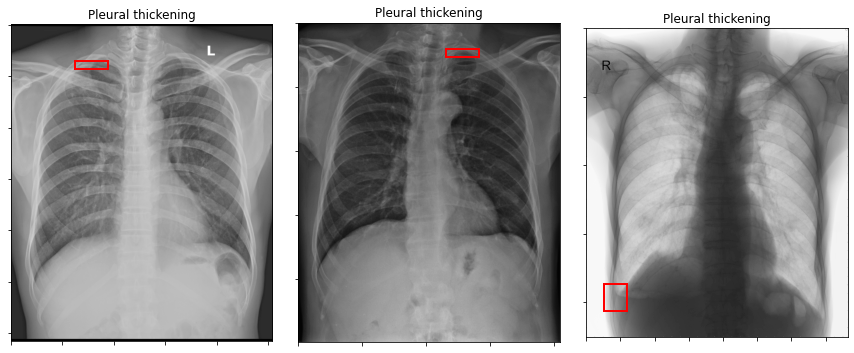

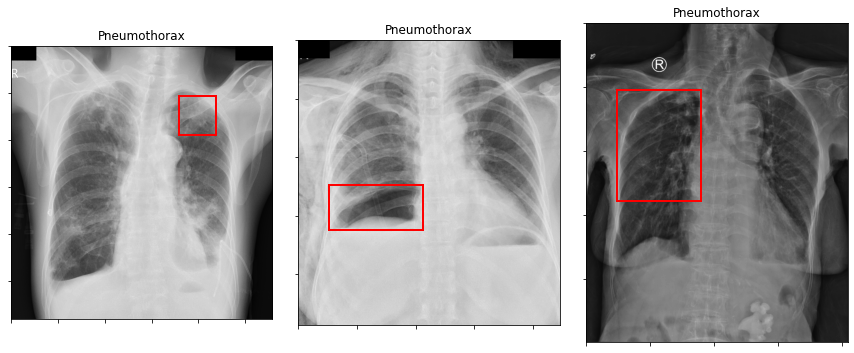

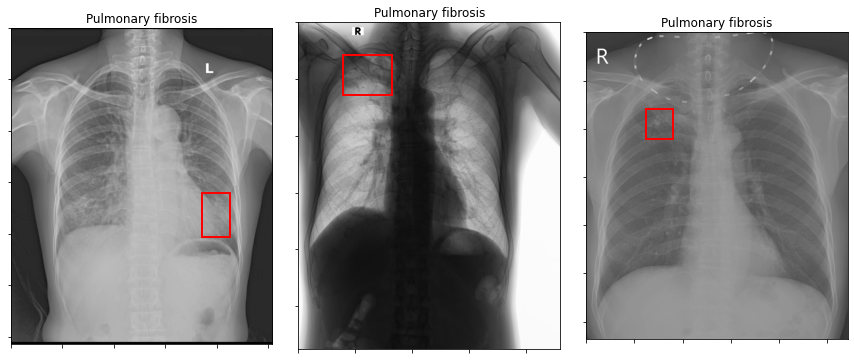

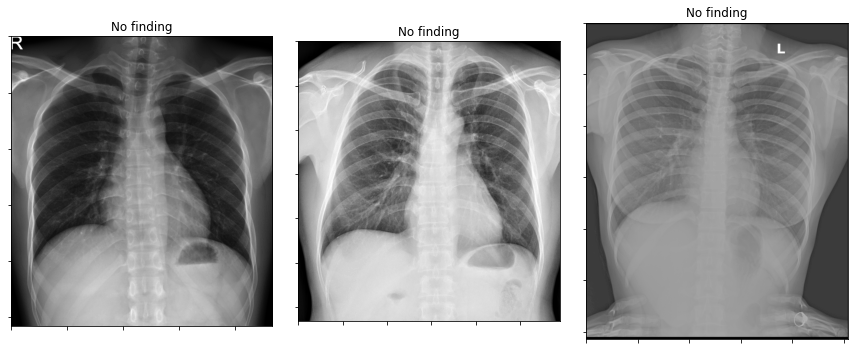

In [12]:
def plot_example(idx_list):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(3):
        image_id = train_data.loc[idx_list[i], 'image_id']
        data_file = dicom.dcmread(path+'train/'+image_id+'.dicom')
        img = data_file.pixel_array
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(train_data.loc[idx_list[i], 'class_name'])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        if train_data.loc[idx_list[i], 'class_name'] != 'No finding':
            bbox = [train_data.loc[idx_list[i], 'x_min'],
                    train_data.loc[idx_list[i], 'y_min'],
                    train_data.loc[idx_list[i], 'x_max'],
                    train_data.loc[idx_list[i], 'y_max']]
            p = matplotlib.patches.Rectangle((bbox[0], bbox[1]),
                                             bbox[2]-bbox[0],
                                             bbox[3]-bbox[1],
                                             ec='r', fc='none', lw=2.)
            axs[i].add_patch(p)
            
for num in range(15):
    idx_list = train_data[train_data['class_id']==num][0:3].index.values
    plot_example(idx_list)

# Write Output


In [13]:
samp_subm.to_csv('submission1.csv', index=False)

#### Solution 2


In [14]:
pred_2class = pd.read_csv("../input/vinbigdata-2class-prediction/2-cls test pred.csv")
low_threshold = 0.001
high_threshold = 0.86
pred_2class

,image_id,target
0,002a34c58c5b758217ed1f584ccbcfe9,0.013326
1,004f33259ee4aef671c2b95d54e4be68,0.037235
2,008bdde2af2462e86fd373a445d0f4cd,0.939700
3,009bc039326338823ca3aa84381f17f1,0.123799
4,00a2145de1886cb9eb88869c85d74080,0.654006
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0.936325
2996,ff9fcc4087ed5e941209aa3fa948e364,0.963583
2997,ffaa288c8abca300974f043b57d81521,0.178720
2998,ffc441e0c8b7153844047483a577e7c3,0.225196


In [15]:
NORMAL = "14 1 0 0 1 1"

pred_det_df = pd.read_csv("../input/vinbigdatastack/submission_postprocessed.csv")
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")


if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:

        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:

        merged_df.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:

        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str("submission2.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

n_normal: 1586 -> 2088 with threshold 0.001 & 0.86
Keep 0 Add 912 Replace 2088
Saved to submission2.csv
